## 17 SDGs classification
This file is meant to perform a multiple class classification on a collection of tagged tweets with an individual tag for a particular SDG (ex:SDG9). For this we will be attempting to classify with a naive bayes (NB from now on) classifier.

In [1]:
import pandas as pd
import re
import joblib # to store model pickle

# Classification
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import metrics

# plot
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Train and test sets
In the first place we need to load the tagged dataset and remove any of the tweets that are tagged with more than one individual SDG as it would not fit the NB approach.

In [3]:
df = pd.read_csv('drive/My Drive/TFG/Datasets/engTagClassDataset.csv', lineterminator='\n')
df.info()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567475 entries, 0 to 567474
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         567475 non-null  int64 
 1   text       567475 non-null  object
 2   tags       567475 non-null  object
 3   #tags      567475 non-null  int64 
 4   cleanText  567475 non-null  object
dtypes: int64(2), object(3)
memory usage: 21.6+ MB


,id,text,tags,#tags,cleanText
0,638601322569310208,@CSBAGUGANDA @FOWODE_UGANDA linking the globa...,[3],1,"['linking', 'global', 'development', 'framewor..."
1,638727916881334272,.@Empower_Women Agree it's abt #SDG17: #ICT &a...,[17],1,"['agree', 'abt', 'sdg17', 'ict', 'innovation',..."
2,638732576283336704,Who agrees w/ me? #Goal2 makes much #SocioEcon...,[2],1,"['agrees', 'w', 'goal2', 'make', 'much', 'soci..."
3,639385607895019520,#SDG2 wants to end hunger by 2030. A challenge...,[2],1,"['sdg2', 'want', 'end', 'hunger', '2030', 'cha..."
4,639455106556166144,"The #SDGs must aim for progress for everyone, ...",[3],1,"['sdgs', 'must', 'aim', 'progress', 'everyone'..."


#### Prepare dataset for train and test split
Before spliting the dataset all explicit tags will be removed from the text. Also, unused attributes will be removed and converted properly.

In [4]:
# Remove explicit tags (remaining words from the original tag #sdg*)
def tagRemove(tweets):
    tweets = tweets.strip("']['").split("', '")
    tweets = [w for w in tweets if not re.fullmatch(r'sdg\d{1,2}', w)]
    return ' '.join([w for w in tweets])

In [5]:
# keep only the tweets that contain one individual tag
dataset_df = df[df['#tags']==1][['text','id','cleanText','tags']]

# cast list representation to list object
dataset_df['tags'] = dataset_df['tags'].apply(lambda x: int(x[1:-1])) # extract values from list since there is only one value
#dataset_df['cleanText'] = dataset_df['cleanText'].apply(lambda x: x.strip('][').split(', '))
#dataset_df['stemtweet'] = dataset_df['cleanText'].apply(lambda x: ' '.join([i[1:-1] for i in x]))
dataset_df['stemtweet'] = df['cleanText'].apply(lambda x: tagRemove(x))

display(dataset_df.head())

,text,id,cleanText,tags,stemtweet
0,@CSBAGUGANDA @FOWODE_UGANDA linking the globa...,638601322569310208,"['linking', 'global', 'development', 'framewor...",3,linking global development framework sdgs ugan...
1,.@Empower_Women Agree it's abt #SDG17: #ICT &a...,638727916881334272,"['agree', 'abt', 'sdg17', 'ict', 'innovation',...",17,agree abt ict innovation mean implementation g...
2,Who agrees w/ me? #Goal2 makes much #SocioEcon...,638732576283336704,"['agrees', 'w', 'goal2', 'make', 'much', 'soci...",2,agrees w goal2 make much socioeconomic sense z...
3,#SDG2 wants to end hunger by 2030. A challenge...,639385607895019520,"['sdg2', 'want', 'end', 'hunger', '2030', 'cha...",2,want end hunger 2030 challenge asia africa sdg...
4,"The #SDGs must aim for progress for everyone, ...",639455106556166144,"['sdgs', 'must', 'aim', 'progress', 'everyone'...",3,sdgs must aim progress everyone everywhere rea...


In [6]:
# Computer doesn't understand text so we need to convert words to tf-idf values
X_text = dataset_df.stemtweet.values
vectorizer = TfidfVectorizer()
vectorizer.fit(X_text)
X_vectorized = vectorizer.transform(X_text)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_vectorized,
                                                    dataset_df['tags'],
                                                    test_size = 0.20,
                                                    shuffle = True)

In [8]:
model = SGDClassifier()
model.fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

In [9]:
# Accuracy Score on Training Data
training_data_accuracy = accuracy_score(pred_train, y_train)
print('Accuracy score on the training data: ',training_data_accuracy)
# Accuracy Score on Test Data
test_data_accuracy = accuracy_score(pred_test, y_test)
print('Accuracy score on the test data: ',test_data_accuracy)

Accuracy score on the training data:  0.8223738377937313
Accuracy score on the test data:  0.8017204089657884


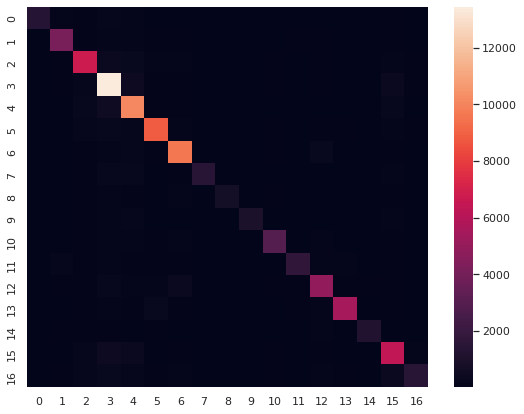

In [10]:
# passing actual and predicted values
cm = confusion_matrix(y_test, pred_test)

# true write data values in each cell of the matrix

sns.set(rc={"figure.figsize":(9, 7)})
sns.heatmap(cm)# annot=True
plt.show()

In [11]:
print(classification_report(y_test, pred_test))
#print('accuracy %s' % accuracy_score(y_pred, y_test))
#print(classification_report(y_test, y_pred,target_names=my_tags))

              precision    recall  f1-score   support

           1       0.80      0.63      0.70      2155
           2       0.80      0.81      0.81      5063
           3       0.79      0.82      0.80      8290
           4       0.79      0.89      0.84     15047
           5       0.78      0.87      0.82     11653
           6       0.88      0.88      0.88     10124
           7       0.84      0.90      0.87     10742
           8       0.79      0.57      0.66      2497
           9       0.77      0.50      0.61      1398
          10       0.80      0.54      0.65      1803
          11       0.78      0.75      0.76      3982
          12       0.76      0.60      0.67      2806
          13       0.77      0.77      0.77      6394
          14       0.88      0.85      0.86      6522
          15       0.80      0.63      0.70      1885
          16       0.75      0.79      0.77      8041
          17       0.69      0.44      0.54      3318

    accuracy              

In [12]:
# store model into pickle
joblib.dump(model, "drive/My Drive/TFG/SDG17.pkl")
joblib.dump(vectorizer, "drive/My Drive/TFG/SDG17_vectorizer.pkl")

['drive/My Drive/TFG/SDG17_vectorizer.pkl']

### 17 SDGs WORDCLOUD
In order to simplify the understanding of relevant common words for each individual SDG, 17 wordclouds with the corresponding lemmatized words will be used. Hopefully, each cloud will give a better understanding on the differentiating words for each SDG. Wordclouds will be built with the original text, having only applied a lowercase normalization.

Word Cloud for SDG 1


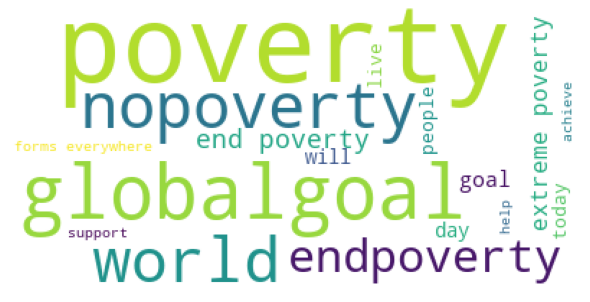

Word Cloud for SDG 2


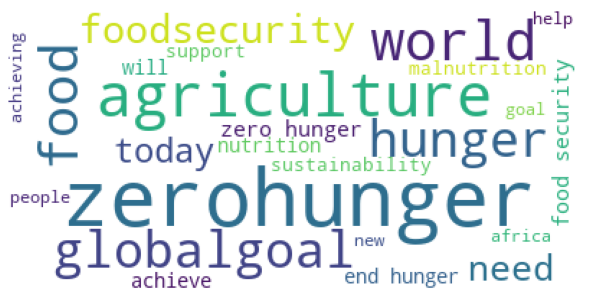

Word Cloud for SDG 3


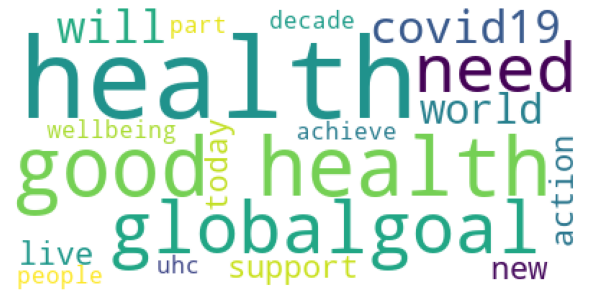

Word Cloud for SDG 4


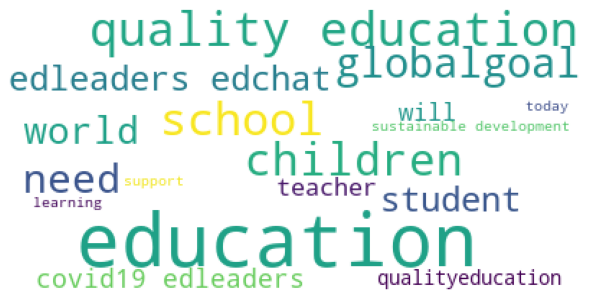

Word Cloud for SDG 5


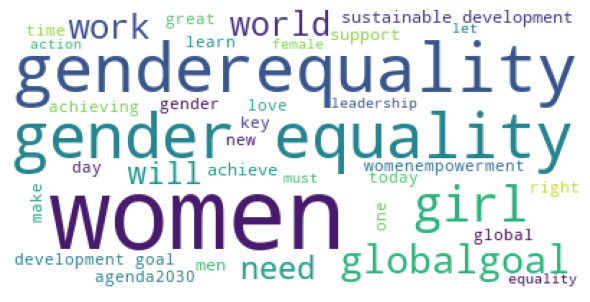

Word Cloud for SDG 6


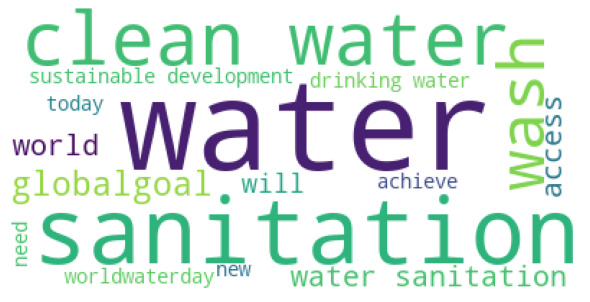

Word Cloud for SDG 7


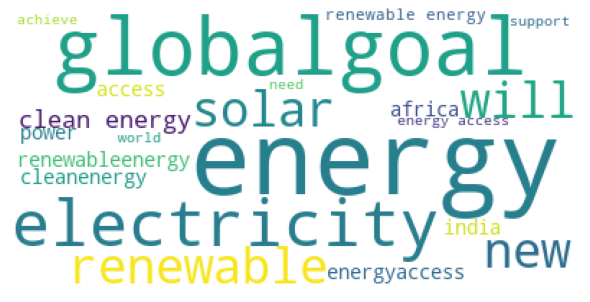

Word Cloud for SDG 8


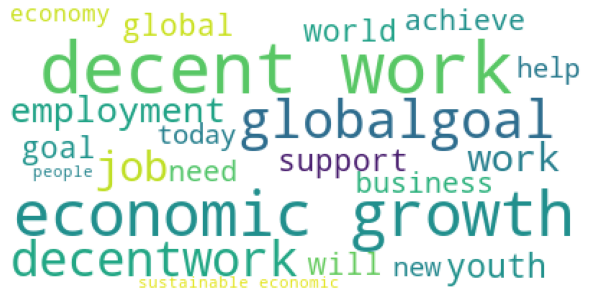

Word Cloud for SDG 9


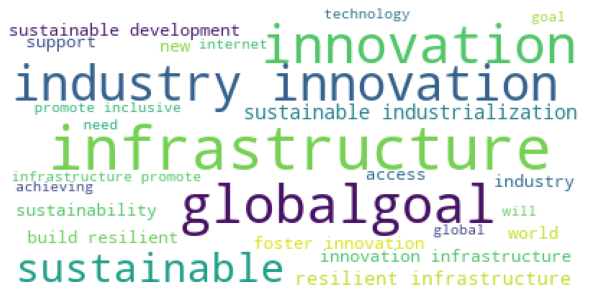

Word Cloud for SDG 10


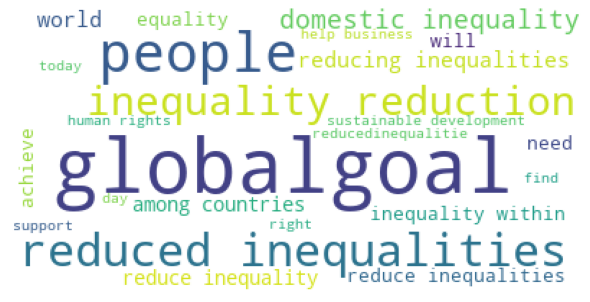

Word Cloud for SDG 11


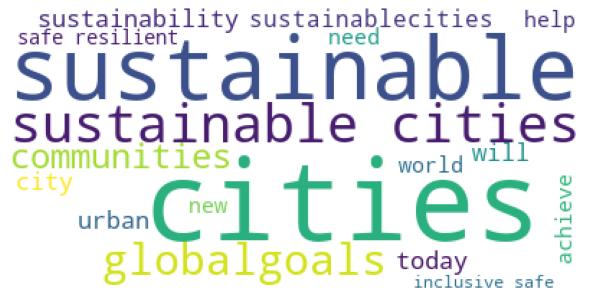

Word Cloud for SDG 12


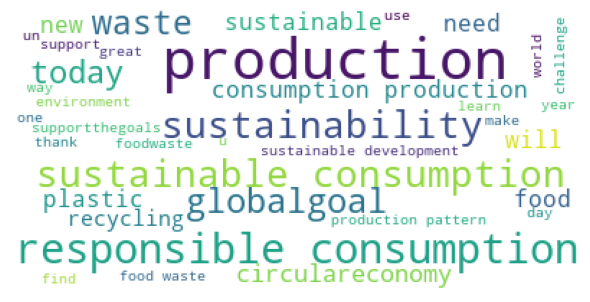

Word Cloud for SDG 13


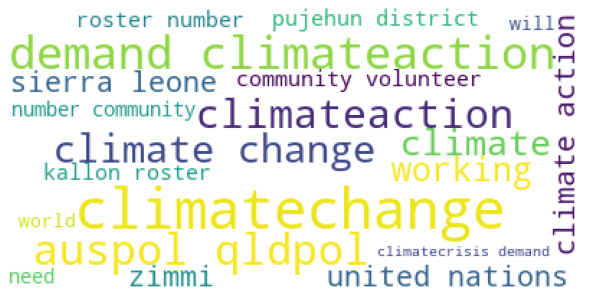

Word Cloud for SDG 14


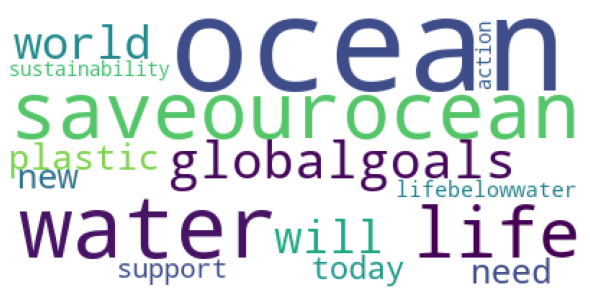

Word Cloud for SDG 15


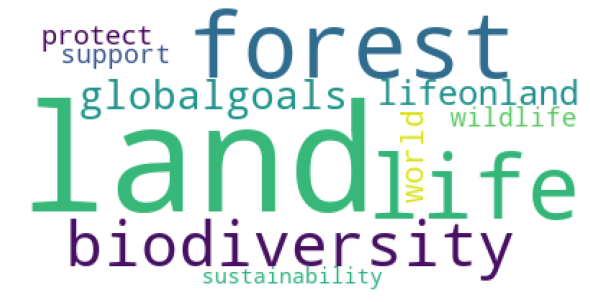

Word Cloud for SDG 16


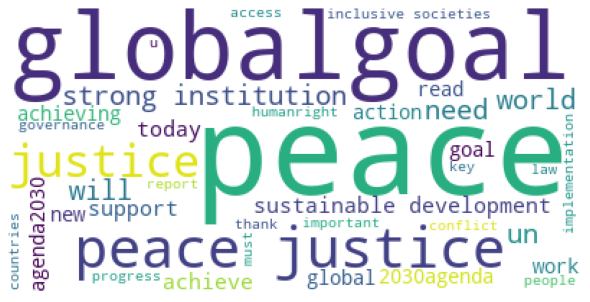

Word Cloud for SDG 17


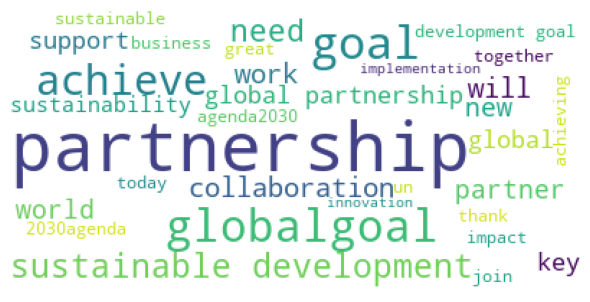

In [ ]:
def wcStringGenerator(goal):
    text = " ".join(list(dataset_df[dataset_df['tags']==goal].text.values)).lower()
    # Remove media links and undisired characters + sdg(s)
    # NOTE: in regex 'or' the order for capture matters
    return re.sub(r"(@[A-Za-z0–9_]+)|#|http\S+|sdgs?|&\w+|[^\w\s]", '', text)

for goal in range(1,18):
    print('Word Cloud for SDG', goal)
    wordcloud = WordCloud(background_color ='white',
                    min_font_size = 10).generate(wcStringGenerator(goal))

    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()